# Topic Analysis
In this notebook I use negative review predictions from the modeling stage to perform topic analysis and identify keywords for the negative reviews. I will the text ranker **`networkx`** to carry out this analysis. Also, I will use a word cloud to visualize the main topics in the reviews.

## Setup

In [0]:
from google.colab import drive
from importlib.machinery import SourceFileLoader
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from wordcloud import WordCloud

%matplotlib inline

Mount Google Drive.

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/Thinkful/Final_Capstone_Project/'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [3]:
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load custom methods and constants.

In [4]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Load Data
Load the review text for reviews classified as negative.

In [0]:
df_negative = pd.read_csv(os.path.join(PROJECT_PATH, 'data/negative_review_predictions.csv'))

In [6]:
df_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
text      106 non-null object
labels    106 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


## Data Preparation
There are a few data preparation steps that need to be taken before performing topic analysis. I will first tokenize the reviews. Then, I will tag the parts-of-speech for each token. During the modeling stage, I will explore how parts-of-speech affect the prediction of topics relavent to negative reviews.

In [0]:
# Load Spacy's toolset
nlp = spacy.load("en_core_web_sm")

In [0]:
df_negative['tokens'] = df_negative['text'].apply(lambda x: [y.text for y in nlp(x)])

In [9]:
df_negative.loc[:5, 'tokens']

0    [lunch, adult, kid, will, reasonable, accommod...
1    [food, okay, bit, underwhelming, honest, servi...
2    [take, husband, celebrate, birthday, adult, ki...
3    [come, happy, hour, Friday, order, food, come,...
4    [second, time, come, expect, better, wrong, ye...
5    [average, food, wait, table, see, table, keep,...
Name: tokens, dtype: object

Combine all reviews together into a single list, which will be the corpus of text.

In [0]:
corpus = []
for review in df_negative['tokens'].values:
  corpus += review

In [11]:
print(f'The corpus of negative reviews contains {len(corpus)} words.')

The corpus of negative reviews contains 6680 words.


Create a list of only the unique words, which will be the vocabulary.

In [0]:
vocab = list(set(corpus))

In [13]:
print(f'The corpus vocabulary size is {len(vocab)} words.')

The corpus vocabulary size is 1709 words.


In [14]:
df_negative['text'].values[:5]

array(['lunch adult kid will reasonable accommodation stroller carseat sit head seat kid infant friendly bring kid know will come',
       'food okay bit underwhelming honest service big miss way recommend',
       'take husband celebrate birthday adult kid come spend dinner eat couple time quality food service believe decline drastically waitress pronounce half dish serve keep inject conversation debate place travel go entire night daughter annoy feel disrespect husband daughter wine pare dinner think sommelier pour wine waitress pour tell wine pronounce correctly dish sit heat lab bit long veggie dry meat dish cook recommend restaurant money burn conversation interrupt',
       'come happy hour Friday order food come right AWAY impressed drink amazing get giddy geisha food mediocre large selection food roll order oyster oyster say run hour ago open hour little disappointing service good place busy offer water refill come check ask check take min physically hand check finally take ove

### Parts-of-Speech
Tag the parts-of-speech for each negative review.

In [0]:
df_negative['POS'] = df_negative['text'].apply(lambda x: [y.pos_ for y in nlp(x)])

In [16]:
df_negative.head()

,text,labels,tokens,POS
0,lunch adult kid will reasonable accommodation ...,1,"[lunch, adult, kid, will, reasonable, accommod...","[NOUN, NOUN, NOUN, VERB, ADJ, NOUN, NOUN, NOUN..."
1,food okay bit underwhelming honest service big...,1,"[food, okay, bit, underwhelming, honest, servi...","[NOUN, INTJ, NOUN, ADJ, ADJ, NOUN, ADJ, NOUN, ..."
2,take husband celebrate birthday adult kid come...,1,"[take, husband, celebrate, birthday, adult, ki...","[VERB, NOUN, VERB, NOUN, NOUN, NOUN, VERB, VER..."
3,come happy hour Friday order food come right A...,1,"[come, happy, hour, Friday, order, food, come,...","[VERB, ADJ, NOUN, PROPN, NOUN, NOUN, VERB, ADV..."
4,second time come expect better wrong year revi...,1,"[second, time, come, expect, better, wrong, ye...","[ADJ, NOUN, VERB, VERB, ADJ, ADJ, NOUN, NOUN, ..."


When searching for relavent words, I will try filtering the text in a few different ways.

#### Exclude adjectives
First, I will remove all adjectives from the reviews, keeping the rest of the text.

In [0]:
def filter_adjectives(tokens, pos):
  filtered = []
  for x, y in zip(tokens, pos):
    if y != 'ADJ':
      filtered.append(x)
  return ' '.join(filtered)

In [0]:
df_negative['no_adjectives'] = df_negative.apply(lambda x: filter_adjectives(x['tokens'], x['POS']), axis=1)

In [19]:
df_negative['no_adjectives'].values[:5]

array(['lunch adult kid will accommodation stroller carseat sit head seat kid infant bring kid know will come',
       'food okay bit service miss way recommend',
       'take husband celebrate birthday adult kid come spend dinner eat couple time quality food service believe decline drastically pronounce half dish serve keep conversation debate place travel go night daughter annoy feel disrespect husband daughter wine pare dinner think pour wine pour tell wine pronounce correctly sit heat lab bit long meat dish cook recommend restaurant money burn conversation interrupt',
       'come hour Friday order food come right AWAY drink get geisha food selection food roll order oyster oyster say run hour ago hour service place offer water refill come check ask check take min physically hand check finally take service food selection bring rating place like atmosphere',
       'time come expect year review star service tell not change customer Asain restaurant tend lack sevice gain go Pho Ha noi

Next, I will only keep the nouns, removing all other words from the reviews.

In [0]:
def only_nouns(tokens, pos):
  filtered = []
  for x, y in zip(tokens, pos):
    if y == 'NOUN':
      filtered.append(x)
  return ' '.join(filtered)

In [0]:

df_negative['only_nouns'] = df_negative.apply(lambda x: only_nouns(x['tokens'], x['POS']), axis=1)

In [22]:
df_negative['only_nouns'].values[:5]

array(['lunch adult kid accommodation stroller carseat head seat kid infant bring kid',
       'food bit service miss way recommend',
       'husband birthday adult kid dinner couple time quality food service decline pronounce half dish conversation debate place travel night daughter annoy disrespect husband daughter wine pare dinner wine pour wine pronounce heat lab bit meat dish cook restaurant money burn conversation interrupt',
       'hour order food drink geisha food selection food roll order oyster oyster hour hour service place offer water refill check check min hand check service food selection place atmosphere',
       'time year review star service customer restaurant tend lack sevice gain noi today experience service mind chance time order sâm straw spoon couple time min time order food sauce sauce disk husband couple time order sâm charge sâm lng waiter sauce dish utensil hand guy apology review extension guy customer time tip meal food time review base experience prove fa

## Relavent Words
I will convert the text into TF-IDF vectors. This will allow me to define cutoffs at document frequency to exclude words that are used more commonly.

Before defining a cutoff, let's look at a distribution in inverse document frequency.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['text'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['text'].values)
encodings = vectorizer.transform(df_negative['text'].values)

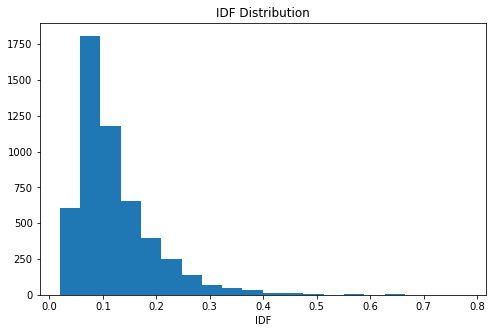

In [33]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution')
ax.set_xlabel('IDF')
plt.show()

Now, I will define a document frequency cutoff of 0.1. This means I will exclude words that are used more than 10% of the time.

In [0]:
vectorizer = TfidfVectorizer(max_df=0.1)
vectorizer.fit(df_negative['text'].values)
idf = vectorizer.idf_
stop_words = vectorizer.stop_words_
vectorizer.fit(df_negative['text'].values)
encodings = vectorizer.transform(df_negative['text'].values)

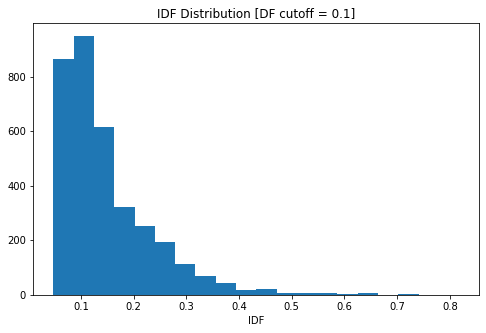

In [35]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [DF cutoff = 0.1]')
ax.set_xlabel('IDF')
plt.show()

### Predict Topics
Gather the vocabulary into a list.

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [37]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 1549 words.


In [38]:
print(f'The first few words of the vocabular are: {vocab[:5]}')

The first few words of the vocabular are: ['lunch', 'adult', 'kid', 'reasonable', 'accommodation']


#### Adjacency
For each word in the corpus, keep track of that word and the neighbors around it.

In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

Remove corpus-specific stop words.

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [41]:
print(f'The corpus size is now {len(corpus_clean)} words.')

The corpus size is now 4211 words.


In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
      df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

#### Text Rank
Calculate TextRank using networkx.

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)

In [0]:
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [48]:
df_rankings.head()

,rank,word
0,0.003165,chicken
1,0.003097,bag
2,0.003067,spot
3,0.002989,noodle
4,0.002951,feel


These words appear to vague. They don't point out specific areas where a restaurant could improve. They also include words like 'feel', which are adjectives. These are qualitative words and do not refer to areas of restaurant improvement.

### No Adjectives
Repeat the analysis as above, but now remove all of the adjectives.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['no_adjectives'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['no_adjectives'].values)
encodings = vectorizer.transform(df_negative['no_adjectives'].values)

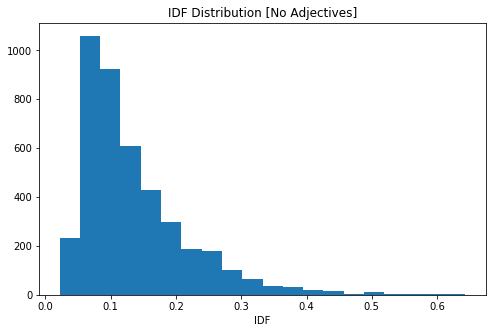

In [50]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [No Adjectives]')
ax.set_xlabel('IDF')
plt.show()

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [52]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 1338 words.


In [53]:
print(f'The first few words of the vocabular are: {vocab[:5]}')

The first few words of the vocabular are: ['lunch', 'adult', 'kid', 'will', 'accommodation']


In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [56]:
print(f'The corpus size is now {len(corpus_clean)} words.')

The corpus size is now 5771 words.


In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
    df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [62]:
df_rankings.head()

,rank,word
0,0.013102,food
1,0.011901,order
2,0.010591,place
3,0.010069,come
4,0.008392,like


Better! These words seem to point more to things, like 'food' and 'place', which refer to specific areas of restaurant improvement. But, the word 'come' does not add much meaning.

Since I am interested in just things, let's try only including nouns.

### Only Nouns
Only use nouns seen in the corpus of negative review text.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['only_nouns'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['only_nouns'].values)
encodings = vectorizer.transform(df_negative['only_nouns'].values)

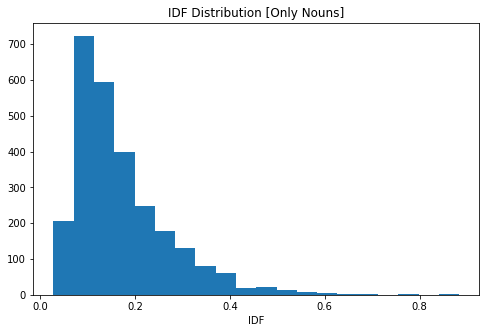

In [64]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [Only Nouns]')
ax.set_xlabel('IDF')
plt.show()

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [66]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 933 words.


In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
    df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [74]:
df_rankings.head()

,rank,word
0,0.016463,food
1,0.014999,order
2,0.013308,place
3,0.010745,service
4,0.009193,time


Excellent! Now, I have specific things that customers are complaining about. 

Let's explore topic further by generating a few visualizations.

## Bar Plot
I will ranks in a bar plot to display the relative importance between different words. To make plot more pleasing, I will normalize the ranks between 0 and 1.

In [0]:
min_rank = df_rankings['rank'].min()
rank_range = df_rankings['rank'].max() - df_rankings['rank'].min()
df_rankings['norm_rank'] = (df_rankings['rank'] - min_rank) / rank_range

In [76]:
df_rankings.head()

,rank,word,norm_rank
0,0.016463,food,1.000000
1,0.014999,order,0.909416
2,0.013308,place,0.804811
3,0.010745,service,0.646305
4,0.009193,time,0.550289


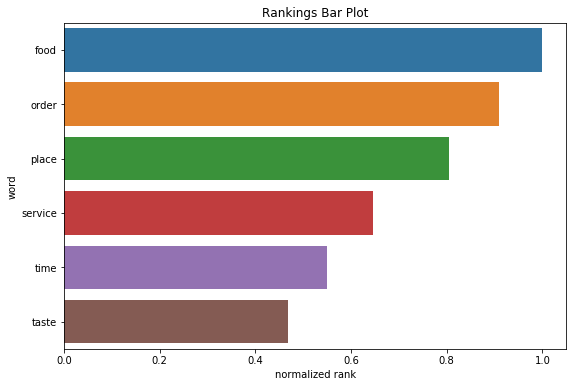

In [82]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(x='norm_rank', y='word', data=df_rankings.loc[:5,:], ax=ax)
ax.set_xlabel('normalized rank')
ax.set_title('Rankings Bar Plot')
plt.show()

## Word Cloud
Another way to visualize the importance of words is creating a word cloud. The size of each word in the below image is related to how much that word is used in the corpus.

In [0]:
corpus_string = ' '.join(corpus_clean)

In [0]:
word_cloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_string)

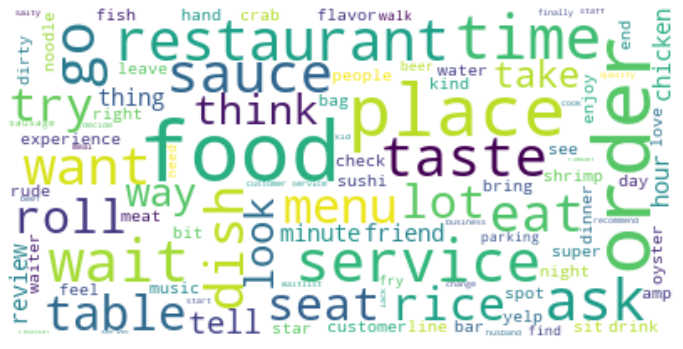

In [89]:
plt.figure(figsize=(12, 7))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Summary and Conclusions
This project addressed the question: _How can restaurants be successful in the South Bay?_ I used review data scrapped from Yelp. Then I performed sentiment analysis, using the ratings as labels and the review text as features. The ratings were split into two groups, positive (4-5 stars) and negative (1-2 stars). I tried four different models and concluded that a simple, multi-layer perceptron model performed the best. The negative review predictions for this model were passed on to the topic analysis phase, where I search for trends in the text that related to areas of improvement for restaurants.

I found that the five main areas of improvement are: **food**, **order**, **place**, **service**, and **time**. Food and order imply problems related to the quality of the food. Service and time, seem related to the customer experience. Place could indicate complaints about the ambiance or decour.